<a href="https://colab.research.google.com/github/kannankumar/jupyter-notebooks/blob/master/MNIST_DCGAN_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST DCGAN
### Generating MNIST digits using DCGAN (in Keras)
-----



In [1]:
# importing libraries

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import keras

Using TensorFlow backend.


In [0]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Dense, Activation, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist

In [0]:
# input dimensions
img_width = 28
img_height = 28
img_channel = 1

img_size = img_width * img_height * img_channel
img_shape = (img_width, img_height, img_channel)

z_dim = 100

In [0]:
# Generator
def build_generator(z_dim=z_dim):
  model = Sequential()
  
  # 100 -> 7*7*256
  model.add(Dense(7*7*256,input_dim=z_dim))
  model.add(Reshape((7,7,256)))

  # 7*7*256 -> 14*14*128
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 14*14*128 -> 14*14*64
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 14*14*64 -> 28*28*1
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
  model.add(Activation('tanh'))

  return model

In [0]:
# Discriminator

def build_discriminator(img_shape=img_shape, img_size=img_size):
  model = Sequential()
  
  # 28*28*1 -> 14*14*32
  model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.1))

  # 14*14*32 -> 14*14*64
  model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 14*14*64 -> 7*7*128
  model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.1))

  # 7*7*128 -> 3*3*256
  model.add(Flatten())
  
  # 3*3*128 -> 1
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  
  return model

In [0]:
# Full GAN model

def build_gan(generator, discriminator):
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  return model

In [0]:
# Build and compile GAN model

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator = build_generator()
discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [0]:
# Training loop

losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_every):

  (x_train, _), (_,_) = mnist.load_data()
  x_train = x_train / 255                   # range 0 to 1
  x_train = x_train*2 - 1                   # change to range -1 to 1
  x_train = np.expand_dims(x_train, axis=3)

  real_labels = np.ones((batch_size,1))
  fake_labels = np.zeros((batch_size,1))

  for iteration in range(iterations):
    # Take a batch of real images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    x = x_train[idx]

    # Take a batch of random noise vectors
    z = np.random.normal(0,1,(batch_size, z_dim))

    # Generate a batch of fake images
    x_star = generator.predict(z)

    # Calculate D loss on real images 
    d_real_loss = discriminator.train_on_batch(x, real_labels)

    # Calculate D loss on fake image
    d_fake_loss = discriminator.train_on_batch(x_star, fake_labels)

    # Calculate total D loss
    d_loss, accuracy = np.add(d_real_loss, d_fake_loss) *0.5

    #**********************************#
    #         Train Generator          #
    #**********************************#

    # Take a batch of random noise vectors
    z = np.random.normal(0,1,(batch_size, z_dim))

    # Generate a batch of fake images
    x_star = generator.predict(z)

    g_loss = gan.train_on_batch(z, real_labels)

    #**********************************#
    #       Iteration Metrics          #
    #**********************************#
    iteration_checkpoints.append(iteration+1)
    losses.append((d_loss, g_loss))

    #**********************************#
    #     Aggregated Step Metrics      #
    #**********************************#
    if (iteration+1) % sample_every == 0:
      print("%d [D Loss: %f] [G Loss: %f]" %(iteration+1, d_loss, g_loss))
      sample_digits(generator)


In [0]:
# Method to show sample images from generator

def sample_digits(generator, num_rows=4, num_cols=4):
  z = np.random.randn(num_rows * num_cols, z_dim)
  imgs = generator.predict(z)

  fig, ax = plt.subplots(num_rows, num_cols, figsize=(4,4), sharex=True, sharey=True)
  
  cnt = 0
  
  for r in range(num_rows):
    for c in range(num_cols):
      ax[r][c].imshow(imgs[cnt, :, :, 0], cmap='binary')
      cnt += 1

### Train DCGAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D Loss: 0.095649] [G Loss: 5.260623]
2000 [D Loss: 0.394478] [G Loss: 5.107279]
3000 [D Loss: 0.028172] [G Loss: 5.250497]
4000 [D Loss: 0.022794] [G Loss: 5.234824]
5000 [D Loss: 0.115489] [G Loss: 4.245416]
6000 [D Loss: 0.214942] [G Loss: 5.302021]
7000 [D Loss: 0.124785] [G Loss: 5.383335]
8000 [D Loss: 0.067066] [G Loss: 6.376248]
9000 [D Loss: 0.164220] [G Loss: 3.867563]
10000 [D Loss: 0.098953] [G Loss: 4.762904]
11000 [D Loss: 0.138581] [G Loss: 4.569250]
12000 [D Loss: 0.158697] [G Loss: 4.746410]
13000 [D Loss: 0.120601] [G Loss: 5.484575]
14000 [D Loss: 0.034337] [G Loss: 6.140319]
15000 [D Loss: 0.061975] [G Loss: 3.713848]
16000 [D Loss: 0.034086] [G Loss: 5.060844]
17000 [D Loss: 0.026383] [G Loss: 6.410822]
18000 [D Loss: 0.040591] [G Loss: 7.450853]
19000 [D Loss: 0.042465] [G Loss: 6.758657]
20000 [D Loss: 0.044256] [G Loss: 3.997595]


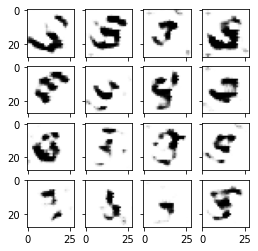

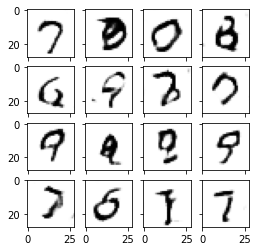

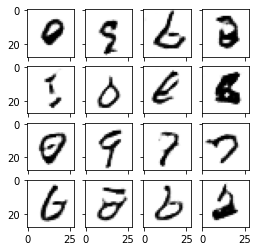

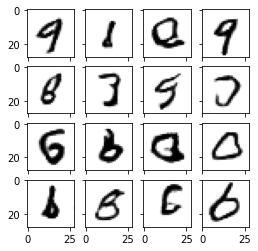

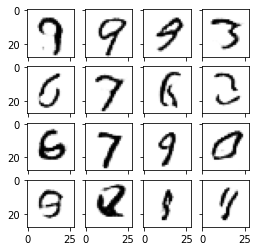

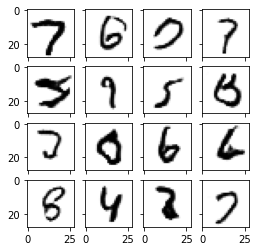

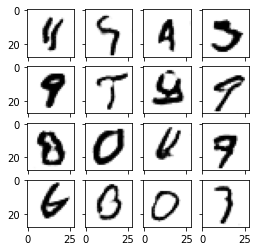

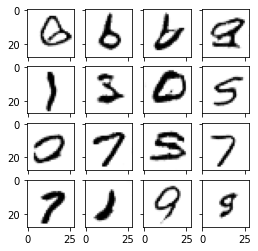

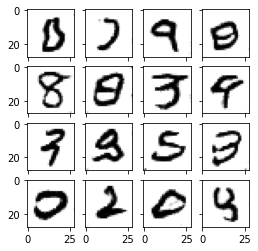

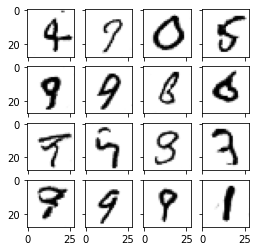

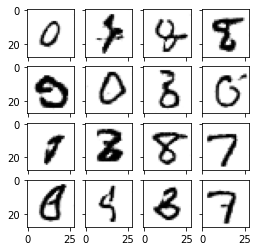

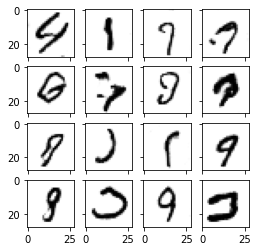

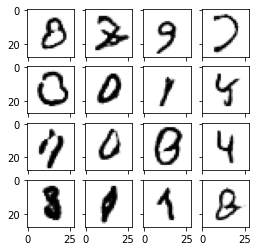

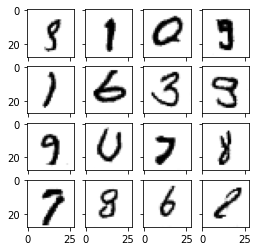

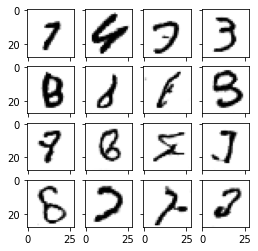

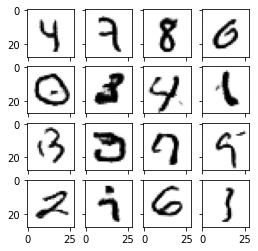

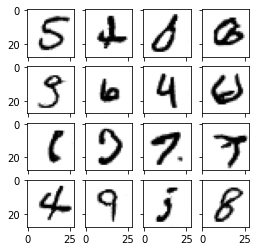

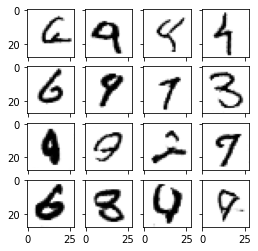

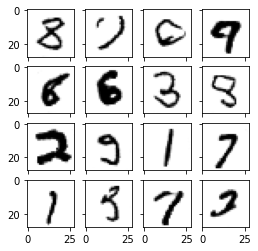

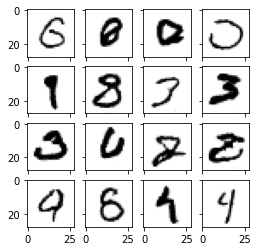

In [34]:
# Run training

iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)

### Visualize Losses

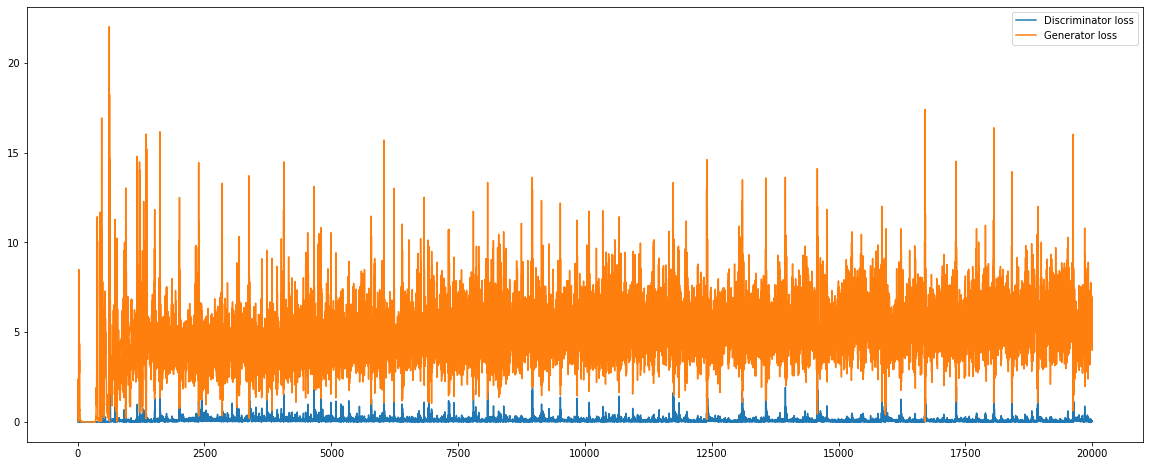

In [36]:
d_loss = [loss[0] for loss in losses]
g_loss = [loss[1] for loss in losses]

plt.figure(figsize=(20,8))
plt.plot(iteration_checkpoints, d_loss, label='Discriminator loss')
plt.plot(iteration_checkpoints, g_loss, label='Generator loss')
plt.legend()